In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

# Load the dataset to explore its structure and contents
file_path = '/kaggle/input/mpea-dataset/MPEA_dataset.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows and summary of the dataset for analysis
dataset.head(), dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   IDENTIFIER: Reference ID                  1545 non-null   int64  
 1   FORMULA                                   1545 non-null   object 
 2   PROPERTY: Microstructure                  1402 non-null   object 
 3   PROPERTY: Processing method               1426 non-null   object 
 4   PROPERTY: BCC/FCC/other                   1545 non-null   object 
 5   PROPERTY: grain size ($\mu$m)             237 non-null    float64
 6   PROPERTY: Exp. Density (g/cm$^3$)         112 non-null    float64
 7   PROPERTY: Calculated Density (g/cm$^3$)   1545 non-null   float64
 8   PROPERTY: HV                              530 non-null    float64
 9   PROPERTY: Type of test                    1150 non-null   object 
 10  PROPERTY: Test temperature ($^\circ$

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(   IDENTIFIER: Reference ID             FORMULA PROPERTY: Microstructure  \
 0                        27  Al0.25 Co1 Fe1 Ni1                      FCC   
 1                        27   Al0.5 Co1 Fe1 Ni1                  FCC+BCC   
 2                        27  Al0.75 Co1 Fe1 Ni1                  FCC+BCC   
 3                        27     Al1 Co1 Fe1 Ni1                      BCC   
 4                        27         Co1 Fe1 Ni1                      FCC   
 
   PROPERTY: Processing method PROPERTY: BCC/FCC/other  \
 0                        CAST                     FCC   
 1                        CAST                   other   
 2                        CAST                   other   
 3                        CAST                     BCC   
 4                        CAST                     FCC   
 
    PROPERTY: grain size ($\mu$m)  PROPERTY: Exp. Density (g/cm$^3$)  \
 0                            NaN                                NaN   
 1                            NaN         

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn

Cleaned dataset saved as 'cleaned_mpea_data.csv'.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


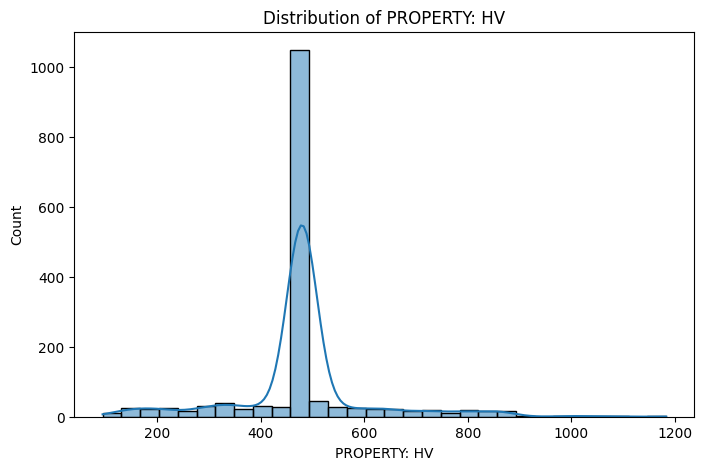

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


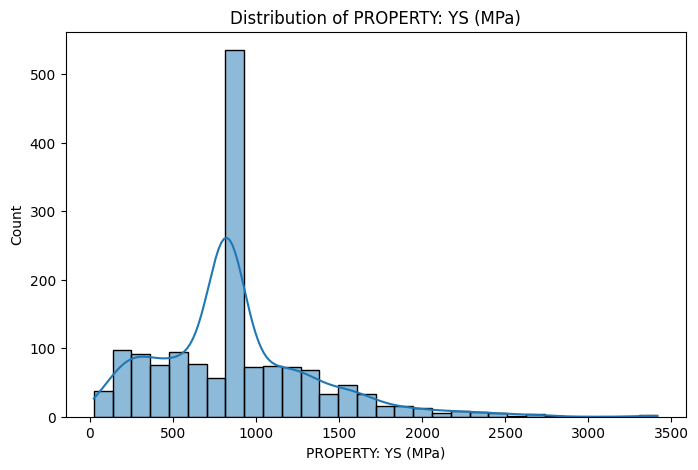

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


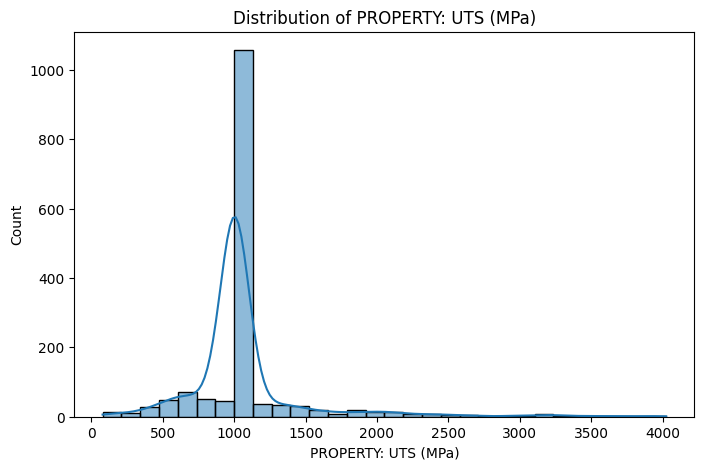

Encoded dataset saved as 'encoded_mpea_data.csv'.
Cleaned Data Shape: (1545, 16)
Encoded Data Shape: (1545, 682)
Training Features Shape: (1236, 679)
Testing Features Shape: (309, 679)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it's in a CSV file named 'mpea_data.csv')
data = pd.read_csv("/kaggle/input/mpea-dataset/MPEA_dataset.csv")

# Step 1: Dataset Cleaning
# Drop columns with extremely high missing values
missing_threshold = 0.7
cols_to_drop = [col for col in data.columns if data[col].isnull().mean() > missing_threshold]
data_cleaned = data.drop(columns=cols_to_drop)

# Fill missing values for numeric columns with median
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].median())

# Fill missing values for categorical columns with mode
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])

# Drop rows where essential columns are missing
essential_cols = ['FORMULA', 'PROPERTY: HV', 'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)']
data_cleaned = data_cleaned.dropna(subset=essential_cols)

# Save the cleaned dataset
data_cleaned.to_csv('/kaggle/working/cleaned_mpea_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_mpea_data.csv'.")

# Step 2: Data Analysis
# Summary statistics
summary_stats = data_cleaned.describe()

# Correlation matrix (only for numeric columns)
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_cleaned[numeric_cols].corr()

# Distribution of target variables
target_cols = ['PROPERTY: HV', 'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)']
for col in target_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_cleaned[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# Step 3: Feature Engineering
# Encoding categorical variables using one-hot encoding
categorical_cols = ['FORMULA', 'PROPERTY: Microstructure', 'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other']
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_cols, drop_first=True)

# Drop non-essential columns like references
non_essential_cols = ['IDENTIFIER: Reference ID', 'REFERENCE: doi', 'REFERENCE: year', 'REFERENCE: title']
data_encoded = data_encoded.drop(columns=non_essential_cols, errors='ignore')

# Save the encoded dataset
data_encoded.to_csv('/kaggle/working/encoded_mpea_data.csv', index=False)
print("Encoded dataset saved as 'encoded_mpea_data.csv'.")

# Step 4: Dataset Splitting
# Define features and targets
X = data_encoded.drop(columns=target_cols)
y = data_encoded[target_cols]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the datasets
print("Cleaned Data Shape:", data_cleaned.shape)
print("Encoded Data Shape:", data_encoded.shape)
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

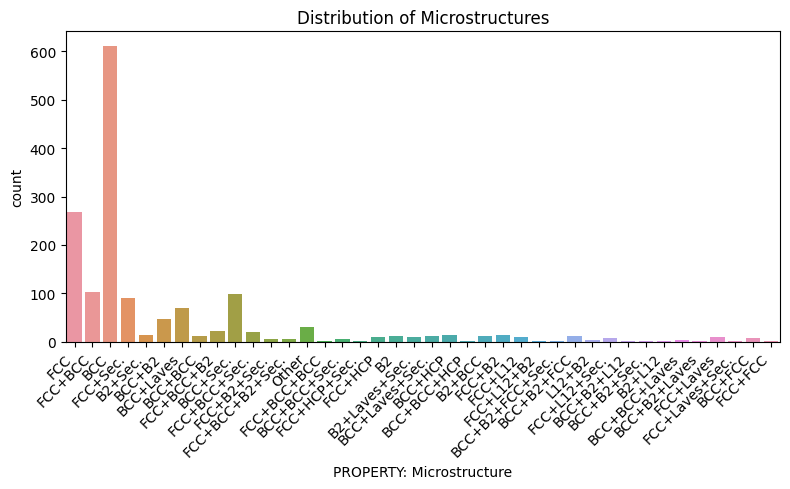

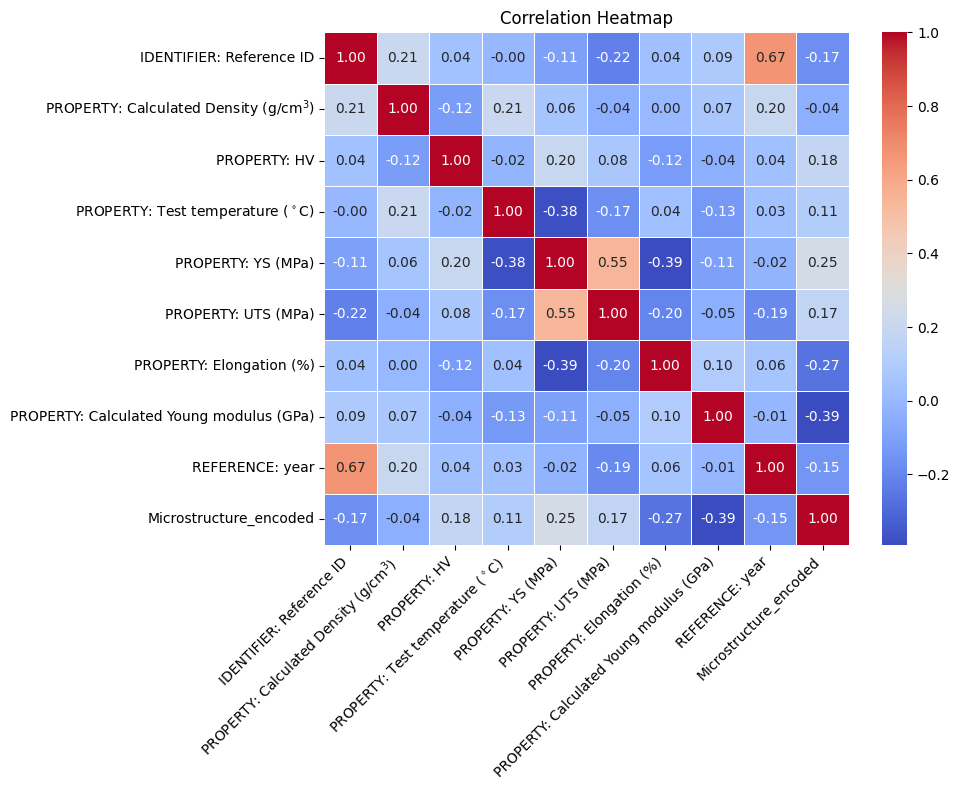

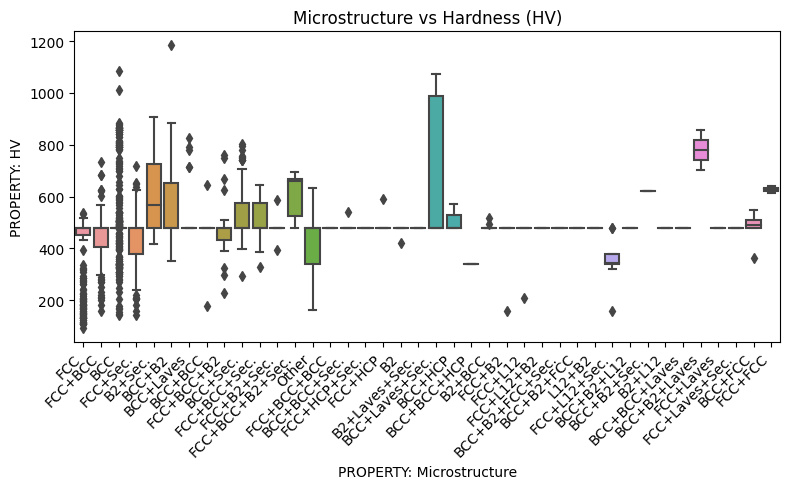

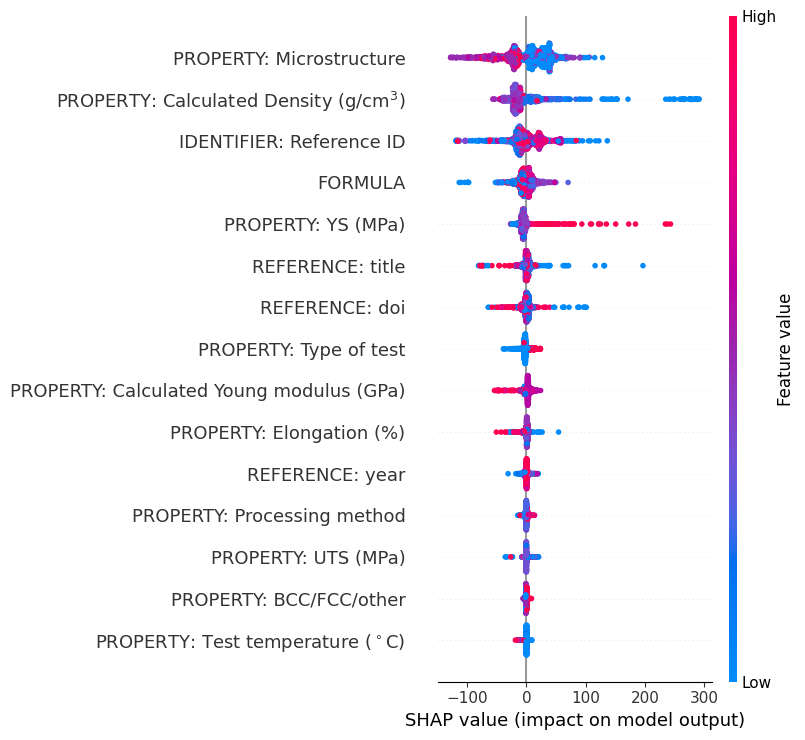

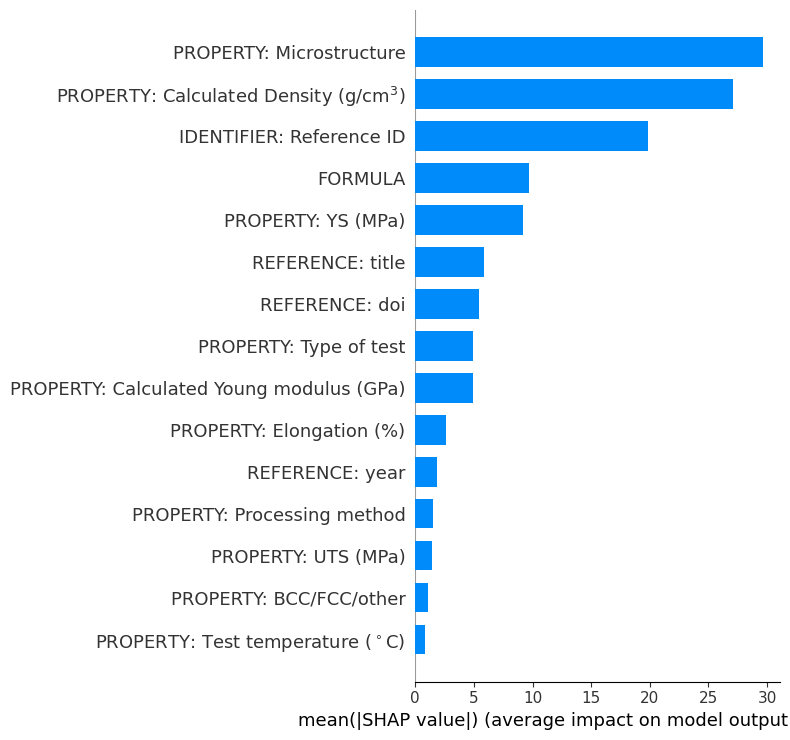

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

# Load the dataset
data = pd.read_csv("/kaggle/working/cleaned_mpea_data.csv")

# Step 1: Data Preprocessing for Microstructure
# Remove rows with missing 'PROPERTY: Microstructure' and 'PROPERTY: HV'
data_cleaned_microstructure = data.dropna(subset=['PROPERTY: Microstructure', 'PROPERTY: HV'])

# Step 2: Correlation between Microstructure and Mechanical Properties
# Encode the 'PROPERTY: Microstructure' column into numerical values
microstructure_mapping = {
    'FCC': 0,
    'BCC': 1,
    'FCC+BCC': 2,
    'other': 3
}
data_cleaned_microstructure['Microstructure_encoded'] = data_cleaned_microstructure['PROPERTY: Microstructure'].map(microstructure_mapping)

# Step 3: Select only numeric columns for correlation analysis
numeric_cols = data_cleaned_microstructure.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data_cleaned_microstructure[numeric_cols].corr()

# Step 4: Visualizations
# Microstructure Distribution Plot
plt.figure(figsize=(8, 5))
sns.countplot(x='PROPERTY: Microstructure', data=data_cleaned_microstructure)
plt.title('Distribution of Microstructures')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
plt.tight_layout()  # Ensure everything fits within the plot area
plt.show()

# Correlation Heatmap of Microstructure and Mechanical Properties
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability and align to right
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Ensure everything fits within the plot area
plt.show()

# Scatter plot of Microstructure vs Hardness (HV)
plt.figure(figsize=(8, 5))
sns.boxplot(x='PROPERTY: Microstructure', y='PROPERTY: HV', data=data_cleaned_microstructure)
plt.title('Microstructure vs Hardness (HV)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
plt.tight_layout()  # Ensure everything fits within the plot area
plt.show()

# Feature Importance from Random Forest or Neural Network Model (For SHAP explanation)
# Assuming the best model is already trained and stored in 'best_rf_model.pkl'
best_rf_model = joblib.load("best_rf_model.pkl")

# SHAP values for model interpretation
# Assuming 'X_train' contains the features used for training the Random Forest model
# Create an explainer for the trained Random Forest model
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_train)

# Feature Importance Plot using SHAP
shap.summary_plot(shap_values, X_train)

# (Optional) If you also want to create a bar plot for feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib

# Load dataset
cleaned_data_path = "/kaggle/working/cleaned_mpea_data.csv"  # Update this with your actual path
data = pd.read_csv(cleaned_data_path)

# Split features and target variables
X = data.drop(['PROPERTY: HV'], axis=1)  # Replace with the target variable of interest
y = data['PROPERTY: HV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features are numeric
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"Encoding column: {col}")
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

# Ensure target variable is numeric
if y_train.dtype == 'object':
    print("Encoding target variable y_train")
    y_train = y_train.astype('category').cat.codes

# Convert data to PyTorch tensors for the neural network
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
rf_best_model = grid_search.best_estimator_

# Evaluate Random Forest
rf_predictions = rf_best_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest Performance:")
print(f"R^2 Score: {rf_r2}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"Root Mean Square Error: {rf_rmse}")

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the neural network
nn_model = NeuralNetwork(input_size=X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the neural network
epochs = 100
for epoch in range(epochs):
    nn_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = nn_model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate the neural network
nn_model.eval()
with torch.no_grad():
    nn_predictions = nn_model(X_test_tensor).numpy().flatten()
nn_r2 = r2_score(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))

print("Neural Network Performance:")
print(f"R^2 Score: {nn_r2}")
print(f"Mean Absolute Error: {nn_mae}")
print(f"Root Mean Square Error: {nn_rmse}")

# Compare performances and save the best model
if rf_r2 > nn_r2:
    print("Random Forest performed better.")
    joblib.dump(rf_best_model, "best_rf_model.pkl")
    model_weights = {
        'model_type': 'RandomForest',
        'n_estimators': rf_best_model.n_estimators,
        'max_depth': rf_best_model.max_depth,
        'min_samples_split': rf_best_model.min_samples_split
    }
else:
    print("Neural Network performed better.")
    torch.save(nn_model.state_dict(), "best_nn_model.pt")
    model_weights = {
        'model_type': 'NeuralNetwork',
        'input_size': X_train.shape[1],
        'hidden_layers': [64, 32],
        'output_size': 1
    }

torch.save(model_weights, "best_model_weights.pt")

Encoding column: FORMULA
Encoding column: PROPERTY: Microstructure
Encoding column: PROPERTY: Processing method
Encoding column: PROPERTY: BCC/FCC/other
Encoding column: PROPERTY: Type of test
Encoding column: REFERENCE: doi
Encoding column: REFERENCE: title
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest Performance:
R^2 Score: 0.024685149618075664
Mean Absolute Error: 67.15432574895117
Root Mean Square Error: 109.75216733381978
Neural Network Performance:
R^2 Score: -0.2590762847863439
Mean Absolute Error: 84.12005739674984
Root Mean Square Error: 124.70007328757765
Random Forest performed better.
